# Training PhaseNet

This tutorial shows how to train a model with SeisBench, using PhaseNet as an example. This brings together the three main components of SeisBench: data, models and generate.

The tutorial is intended to highlight the basic principles of training models in SeisBench. However, this will not necessarily be best practice for more elaborate experiments. As a reference how to set up larger studies and which augmentations can be used for which models, we refer to the implementation of our pick benchmark at [https://github.com/seisbench/pick-benchmark](https://github.com/seisbench/pick-benchmark).

*Note: As this tutorial brings together different parts of seisbench, it is recommended to go through the basic tutorials first before beginning this tutorial. In addition, this tutorial assumes some familiarity with pytorch*

In [1]:
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
from seisbench.util import worker_seeding

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

from seisbench.data import WaveformDataset
from torch.utils.data import DataLoader
from augmentations import ChangeChannels
from augmentations import DuplicateEvent
from tqdm import tqdm


## Model and data

We create a randomly initialized PhaseNet model using `seisbench.models`. If available, you can move your model onto the GPU for faster training.

In [2]:
model = sbm.EQTransformer(in_channels=1)
model.cuda();


In [3]:
data = WaveformDataset("/home/trahn/.seisbench/datasets/stead/")
train, dev, test = data.train_dev_test()


## Generation pipeline

The ETHZ dataset contains detailed labels for the phases. However, for this example we only want to differentiate between P and S picks. Therefore, we define a dictionary mapping the detailed picks to their phases.

In [4]:
phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_pP_arrival_sample": "P",
    "trace_P_arrival_sample": "P",
    "trace_P1_arrival_sample": "P",
    "trace_Pg_arrival_sample": "P",
    "trace_Pn_arrival_sample": "P",
    "trace_PmP_arrival_sample": "P",
    "trace_pwP_arrival_sample": "P",
    "trace_pwPm_arrival_sample": "P",
    "trace_s_arrival_sample": "S",
    "trace_S_arrival_sample": "S",
    "trace_S1_arrival_sample": "S",
    "trace_Sg_arrival_sample": "S",
    "trace_SmS_arrival_sample": "S",
    "trace_Sn_arrival_sample": "S",
}


Now we define two generators with identical augmentations, one for training, one for validation. The augmentations are:
1. Selection of a (long) window around a pick. This way, we ensure that out data always contains a pick.
1. Selection of a random window with 3001 samples, the input length of PhaseNet.
1. A normalization, consisting of demeaning and amplitude normalization.
1. A change of datatype to float32, as this is expected by the pytorch model.
1. A probabilistic label

In [5]:
def get_joint_augmentations(sample_boundaries, sigma):
    p_phases = [key for key, val in phase_dict.items() if val == "P"]
    s_phases = [key for key, val in phase_dict.items() if val == "S"]


    detection_labeller = sbg.DetectionLabeller(
        p_phases, s_phases=s_phases, key=("X", "detections")
    )

    block1 = [
        # In 2/3 of the cases, select windows around picks, to reduce amount of noise traces in training.
        # Uses strategy variable, as padding will be handled by the random window.
        # In 1/3 of the cases, just returns the original trace, to keep diversity high.
        sbg.OneOf(
            [
                sbg.WindowAroundSample(
                    list(phase_dict.keys()),
                    samples_before=6000,
                    windowlen=12000,
                    selection="random",
                    strategy="variable",
                ),
                sbg.NullAugmentation(),
            ],
            probabilities=[2, 1],
        ),
        sbg.RandomWindow(
            low=sample_boundaries[0],
            high=sample_boundaries[1],
            windowlen=6000,
            strategy="pad",
        ),
        sbg.ProbabilisticLabeller(
            label_columns=phase_dict, sigma=sigma, dim=0
        ),
        detection_labeller,
        # Normalize to ensure correct augmentation behavior
        sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    ]

    block2 = [
        sbg.ChangeDtype(np.float32, "X"),
        sbg.ChangeDtype(np.float32, "y"),
        sbg.ChangeDtype(np.float32, "detections"),
        ChangeChannels(0)
    ]

    return block1, block2

def get_train_augmentations(rotate_array=False):
    if rotate_array:
        rotation_block = [
            sbg.OneOf(
                [
                    sbg.RandomArrayRotation(["X", "y", "detections"]),
                    sbg.NullAugmentation(),
                ],
                [0.99, 0.01],
            )
        ]
    else:
        rotation_block = []

    augmentation_block = [
        # Add secondary event
        sbg.OneOf(
            [DuplicateEvent(label_keys="y"), sbg.NullAugmentation()],
            probabilities=[0.3, 0.7],
        ),
        # Gaussian noise
        sbg.OneOf([sbg.GaussianNoise(), sbg.NullAugmentation()], [0.5, 0.5]),
        # Array rotation
        *rotation_block,
        # Gaps
        sbg.OneOf([sbg.AddGap(), sbg.NullAugmentation()], [0.2, 0.8]),
        # Channel dropout
        sbg.OneOf([sbg.ChannelDropout(), sbg.NullAugmentation()], [0.3, 0.7]),
        # Augmentations make second normalize necessary
        sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    ]

    block1, block2 = get_joint_augmentations(sample_boundaries=(None, None), sigma=20)

    return block1 + augmentation_block + block2

def get_val_augmentations():
    block1, block2 = get_joint_augmentations(sample_boundaries=(None, None), sigma=20)

    return block1 + block2


In [6]:
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)
test_generator = sbg.GenericGenerator(test)


train_generator.add_augmentations(get_train_augmentations(rotate_array=True))
dev_generator.add_augmentations(get_val_augmentations())
test_generator.add_augmentations(get_val_augmentations())


Let's visualize a few training examples. Everytime you run the cell below, you'll see a different training example.

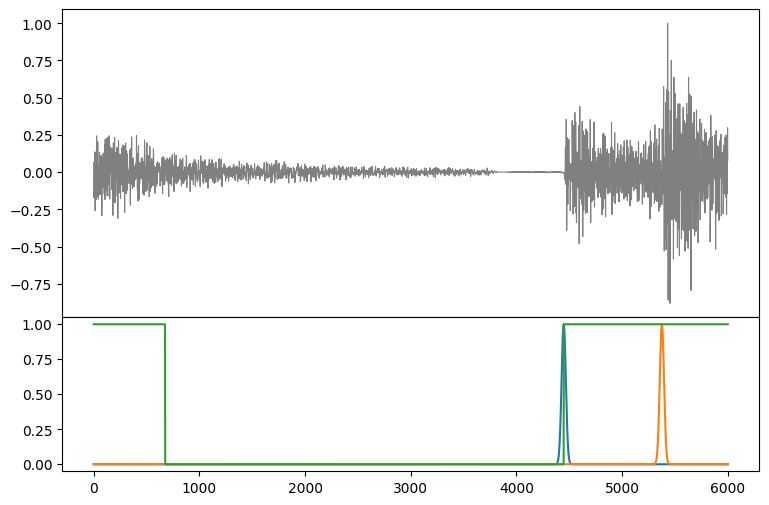

In [7]:
sample = train_generator[np.random.randint(len(train_generator))]

fig = plt.figure(figsize=(9, 6))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [2, 1]})

axs[0].plot(sample["X"].T, color='gray', linewidth='0.8')
axs[1].plot(sample["y"][:2].T)
axs[1].plot(sample["detections"].T)


SeisBench generators are pytorch datasets. Therefore, we can pass them to pytorch data loaders. These will automatically take care of parallel loading and batching. Here we create one loader for training and one for validation. We choose a batch size of 256 samples. This batch size should fit on most hardware.

In [8]:
batch_size = 512
num_workers = 24  # The number of threads used for loading data

train_loader = DataLoader(train_generator, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding)
dev_loader = DataLoader(dev_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)
test_loader = DataLoader(test_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)


## Training a model

Now we got all components for training the model. What we still need to do is define the optimizer and the loss, and write the training and validation loops.

In [9]:
learning_rate = 1e-3
epochs = 10

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fc = torch.nn.BCELoss()

def loss_fn(y_pred, y_true, det_true):
    # vector cross entropy loss
    p_true = y_true[:, 0]
    s_true = y_true[:, 1]
    det_true = det_true[:, 0]

    det_pred = y_pred[:,0]
    p_pred = y_pred[:,1]
    s_pred = y_pred[:,2]

    return (
        0.05 * loss_fc(det_pred.float(), det_true.float())
        + 0.4 * loss_fc(p_pred.float(), p_true.float())
        + 0.55 * loss_fc(s_pred.float(), s_true.float())
    )


In [10]:
def train_loop(dataloader):
    model.train()
    loss = 0.0
    pbar = tqdm(dataloader)
    for batch in pbar:
        # Adapt process bar descrption
        pbar.set_description(f"loss: {loss:>7f}")
        pbar.refresh()

        # Compute prediction and loss
        pred = model(batch["X"].to(model.device))
        loss = loss_fn(pred, batch["y"].to(model.device), batch["detections"].to(model.device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss = loss.item()


def test_loop(dataloader):
    num_batches = len(dataloader)
    test_loss = 0

    model.eval()  # close the model for evaluation

    with torch.no_grad():
        for batch in dataloader:
            pred = model(batch["X"].to(model.device))
            test_loss += loss_fn(pred, batch["y"].to(model.device), batch["detections"].to(model.device)).item()

    model.train()  # re-open model for training stage

    test_loss /= num_batches
    print(f"Test avg loss: {test_loss:>8f} \n")


In [11]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader)
    test_loop(dev_loader)


Epoch 1
-------------------------------


loss: 0.033823: 100%|██████████| 2102/2102 [06:05<00:00,  5.75it/s]


Test avg loss: 0.013858 

Epoch 2
-------------------------------


loss: 0.032059: 100%|██████████| 2102/2102 [06:00<00:00,  5.82it/s]


Test avg loss: 0.012841 

Epoch 3
-------------------------------


loss: 0.028775: 100%|██████████| 2102/2102 [06:01<00:00,  5.82it/s]


Test avg loss: 0.012764 

Epoch 4
-------------------------------


loss: 0.027769: 100%|██████████| 2102/2102 [06:02<00:00,  5.80it/s]


Test avg loss: 0.013174 

Epoch 5
-------------------------------


loss: 0.028920: 100%|██████████| 2102/2102 [06:01<00:00,  5.82it/s]


Test avg loss: 0.012302 

Epoch 6
-------------------------------


loss: 0.028775:   0%|          | 6/2102 [00:09<55:08,  1.58s/it]  


KeyboardInterrupt: 

## Evaluating the model

Not that we trained the model, we can evaluate it. First, we'll check how the model does on an example from the development set. Note that the model will most likely not be fully trained after only five epochs.

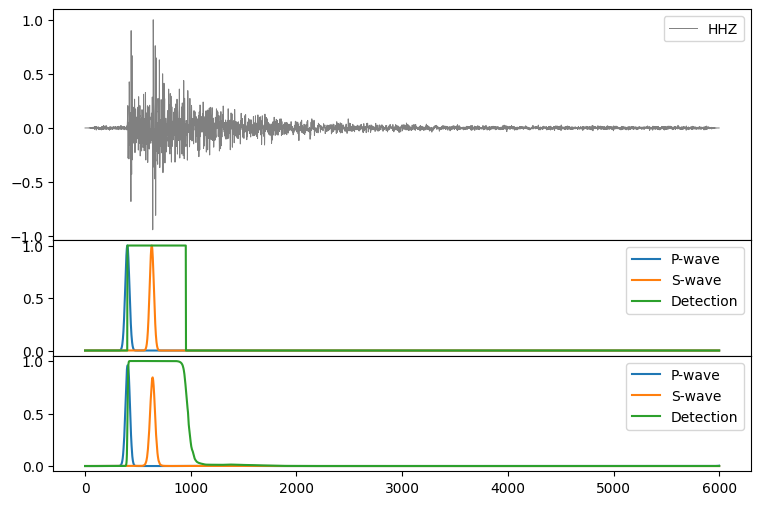

In [14]:
sample = dev_generator[np.random.randint(len(dev_generator))]

fig = plt.figure(figsize=(9, 6))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [2, 1, 1]})
axs[0].plot(sample["X"].T, color='gray', linewidth='0.7', label='HHZ')
axs[1].plot(sample["y"][:2].T, label=['P-wave','S-wave'])
axs[1].plot(sample["detections"].T, label='Detection')

model.eval()  # close the model for evaluation

with torch.no_grad():
    pred = model(torch.tensor(sample["X"], device=model.device).unsqueeze(0))  # Add a fake batch dimension
    pred = pred[0].cpu().numpy()

pred_rearanged = np.empty(pred.shape)
pred_rearanged[0] = pred[1]
pred_rearanged[1] = pred[2]
pred_rearanged[2] = pred[0]

axs[2].plot(pred_rearanged.T, label=['P-wave','S-wave','Detection'])

for ax in axs:
    ax.legend()


As a second option, we'll directly apply our model to an obspy waveform stream using the `annotate` function. For this, we are downloading waveforms through FDSN and annotating them. Note that you could use the `classify` function in a similar fashion.

As we trained the model on Swiss data, we use an example event from Switzerland. Note that we deliberately chose a rather easy example, as the model is not fully trained after the low number of epochs. The exact performance of the model will vary depending, because the model training and initialization involves random aspects.

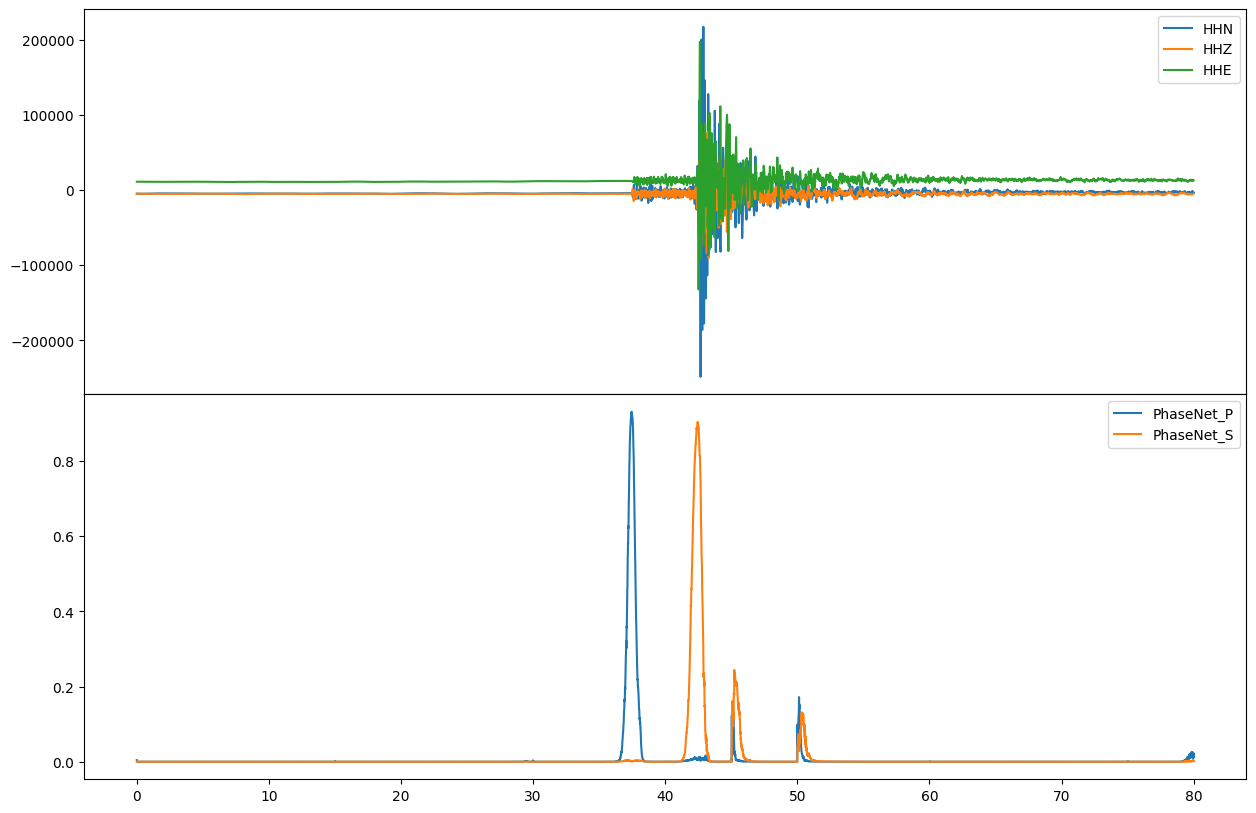

In [12]:
client = Client("ETH")

t = UTCDateTime("2019-11-04T00:59:46.419800Z")
stream = client.get_waveforms(network="CH", station="EMING", location="*", channel="HH?", starttime=t-30, endtime=t+50)

annotations = model.annotate(stream)

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})

offset = annotations[0].stats.starttime - stream[0].stats.starttime
for i in range(3):
    axs[0].plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
    if annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
        axs[1].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].stats.channel)

axs[0].legend()
axs[1].legend()


## Remarks

As discussed in the data basics tutorial, loading a SeisBench dataset only means loading the metadata into memory. The waveforms are only loaded once they are requested to save memory. By default, waveforms are **not** cached in memory. For training, this means that the data needs to be read from the file in every epoch again. Depending on your hardware, this will take a lot of time. To solve this issue, you can set the `cache` option, when creating the dataset. Then, all you have to do is call `preload_waveforms` and the data will be loaded into memory and automatically cached. For most practical applications, this option is recommended.